In [39]:
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pandas as pd

from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

from sklearn.metrics import balanced_accuracy_score, confusion_matrix

import sklearn
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math

# custom function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
# some_file.py
import sys
#change location to GNN_RIVM folder
sys.path.insert(1, '/home/jeroen/Documents/Toxic/GNN_rivm/benchmark')

from nets.TUs_graph_classification.load_net import gnn_model # import GNNs
from data.data import LoadData # import dataset
from train.train_TUs_graph_classification import train_epoch, evaluate_network, evaluate_network2 # import train functions

drop_last = False
device = torch.device("cpu")

In [1]:
def create_net_params(file_name):
    f = open(file_name, "r")
    n_params = (f.readlines()[5].split(" "))
#     for i in (list(enumerate(n_params))):
#         print(i)
    net_params = dict()
    pbt_params_int = ["in_dim", "L", "hidden_dim", "out_dim","n_classes"]
    int_idx = [21,1,3,5,23]
    pbt_params_str = [ 'readout', 'gated']
    str_idx = [7,9]
    
    for idx1, par in enumerate(pbt_params_int):
        net_params[par] = int(n_params[int_idx[idx1]].split(',')[0])
    net_params['dropout'] = float(n_params[13].split(',')[0])
    net_params['in_feat_dropout'] = float(n_params[11].split(',')[0])
    for idx2, par in enumerate(pbt_params_str):
        net_params[par] =  n_params[str_idx[idx2]].split(',')[0].strip("'")
    return net_params 

In [2]:
folder = "MLPCMR/"
model_str = "MLP"

gin1_file = "MLP_CMR_Rep1_GPU0_12h03m32s_on_Jul_02_2020"
gin2_file = "MLP_CMR_Rep2_GPU0_12h03m32s_on_Jul_02_2020"
gin3_file = "MLP_CMR_Rep3_GPU0_12h03m31s_on_Jul_02_2020"
gin4_file = "MLP_CMR_Rep4_GPU0_12h03m34s_on_Jul_02_2020"

gin1_np = create_net_params(folder+"config_"+gin1_file+".txt")
gin2_np = create_net_params(folder+"config_"+gin2_file+".txt")
gin3_np = create_net_params(folder+"config_"+gin3_file+".txt")
gin4_np = create_net_params(folder+"config_"+gin4_file+".txt")

In [3]:
gin1_np['gated'] = False
gin2_np['gated'] = False
gin3_np['gated'] = False
gin4_np['gated'] = False

In [4]:
print(gin1_np)
print(gin2_np)
print(gin3_np)
print(gin4_np)

{'in_dim': 17, 'L': 2, 'hidden_dim': 200, 'out_dim': 128, 'n_classes': 2, 'dropout': 0.5, 'in_feat_dropout': 0.5, 'readout': 'mean', 'gated': False}
{'in_dim': 25, 'L': 2, 'hidden_dim': 50, 'out_dim': 128, 'n_classes': 2, 'dropout': 0.5, 'in_feat_dropout': 0.5, 'readout': 'mean', 'gated': False}
{'in_dim': 21, 'L': 2, 'hidden_dim': 50, 'out_dim': 128, 'n_classes': 2, 'dropout': 0.5, 'in_feat_dropout': 0.5, 'readout': 'mean', 'gated': False}
{'in_dim': 88, 'L': 2, 'hidden_dim': 200, 'out_dim': 128, 'n_classes': 2, 'dropout': 0.5, 'in_feat_dropout': 0.5, 'readout': 'mean', 'gated': False}


In [25]:
dataset1 = LoadData("CMR_Rep1")
dataset2 = LoadData("CMR_Rep2")
dataset3 = LoadData("CMR_Rep3")
dataset4 = LoadData("CMR_Rep4")

652
preparing 652 graphs for the ALL set...
[!] Dataset:  CMR_Rep1
Time taken: 4.2103s
652
preparing 652 graphs for the ALL set...
[!] Dataset:  CMR_Rep2
Time taken: 8.3963s
652
preparing 652 graphs for the ALL set...
[!] Dataset:  CMR_Rep3
Time taken: 7.1424s
652
preparing 652 graphs for the ALL set...
[!] Dataset:  CMR_Rep4
Time taken: 4.1555s


In [26]:
drop_last = False
device = torch.device("cpu")

In [27]:
def test_model(net_params, model_name, dataset, model_str):
    accs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
#         train_loader = DataLoader(trainset, batch_size=20, shuffle=True, drop_last=drop_last, collate_fn=dataset.collate)
#         val_loader = DataLoader(valset, batch_size=20, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, epoch_val_acc = evaluate_network(model, device, test_loader, 999)
        accs.append(epoch_val_acc)
    print(np.mean(accs),np.std(accs))
#     print(accs)

In [28]:
def test_model2(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.extend(score)
        labs.extend(labels)
    return accs, labs

In [29]:
def test_model3(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.append(score)
        labs.append(labels)
    return accs, labs

In [30]:
test_model(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
test_model(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
test_model(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
test_model(gin4_np, folder+gin4_file+"/RUN_", daataset4, model_str)

0.6116530642846432 0.05048124312748367
0.6664770901613007 0.06673211324792734
0.6763321230426493 0.04684849665174236
0.7794215774478932 0.05973279780251743


In [33]:
accs1, labels1 = test_model2(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
accs2, labels2 = test_model2(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
accs3, labels3 = test_model2(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
accs4, labels4 = test_model2(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

In [34]:
acclist1, lablist1 = test_model3(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
acclist2, lablist2 = test_model3(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
acclist3, lablist3 = test_model3(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
acclist4, lablist4 = test_model3(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

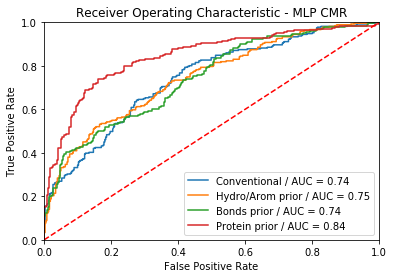

In [37]:
accuracies = [accs1, accs2, accs3, accs4]
acclists = [acclist1, acclist2, acclist3, acclist4]

labels = ["Conventional", "Hydro/Arom prior", "Bonds prior", "Protein prior"]
for idx, ac in enumerate(accuracies):
    fpr, tpr, threshold = metrics.roc_curve(labels1, sigmoid(np.array(ac))[:,1])
    roc_auc = metrics.roc_auc_score(labels1, sigmoid(np.array(ac))[:,1])
    plt.title('Receiver Operating Characteristic - MLP CMR')
    plt.plot(fpr, tpr, label = labels[idx]+' / AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
for acc in acclists:
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc):
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
#     print(rec)
    print("%.4f %.4f" % (np.mean(pre), np.mean(rec)))
#     print("%.4f" % np.mean(pre), np.std(pre))

0.8219 0.2653
0.6752 0.5087
0.7598 0.4684
0.7937 0.6898


In [41]:
from collections import Counter
idx_wrong = []
idx_wrong2 = []
for acc in accuracies:
    idx_wrong.append(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    idx_wrong2.extend(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    
idx_allwrong  = sorted(list(set(idx_wrong[0])&set(idx_wrong[1])&set(idx_wrong[2])&set(idx_wrong[3])))
print(Counter(Counter(idx_wrong2).values()))
print(len(Counter(idx_wrong2)))

Counter({1: 101, 2: 85, 3: 78, 4: 58})
322


In [42]:
accuracies = [accs1, accs2, accs3, accs4]
for acc in accuracies:
    print(confusion_matrix(labels1, np.argmax(acc, axis=1)))

[[365  16]
 [199  72]]
[[314  67]
 [133 138]]
[[337  44]
 [144 127]]
[[331  50]
 [ 84 187]]


In [43]:
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        acc_temp.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(acc_temp), np.std(acc_temp)])
        
df = pd.DataFrame(accs)
print(df)

   0         1         2
0  0  0.611653  0.050481
1  1  0.647385  0.065447
2  2  0.652895  0.047678
3  3  0.754143  0.054948


In [44]:
rep123=[]
rep124=[]
rep1234=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep123.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep124.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print(np.mean(rep123), np.std(rep123))
print(np.mean(rep124), np.std(rep124))
print(np.mean(rep1234), np.std(rep1234))

0.6662618083670715 0.05002335456576691
0.6662618083670715 0.05002335456576691
0.7176565880513249 0.06403697596003637


In [45]:
accs = []
for idx1, acc1 in enumerate(accuracies):
    pred = []
    acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(acc1)))/2
    print(idx1+1)
    print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

1
[[365  16]
 [199  72]]
2
[[353  28]
 [171 100]]
3
[[350  31]
 [166 105]]
4
[[347  34]
 [109 162]]


In [46]:
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

[[349  32]
 [158 113]]
[[353  28]
 [112 159]]
[[353  28]
 [133 138]]


In [ ]:
# print(np.array(accuracies[1])[idx_allwrong])
# print(np.array(labels1)[idx_allwrong])
# print(list(np.array(test)[idx_allwrong]))

In [ ]:
# check = [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# print(np.array(check)[np.array(test)[idx_allwrong]])
# print(np.array(labels1)[idx_allwrong])
# print([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0])
# print(sum(np.array(check)[test] == labels1))

In [ ]:
# print(idx_allwrong)
# print(sorted(list(np.array(test)[idx_allwrong])))
# print(np.array(labels1)[idx_allwrong])
# [1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0]